In [1]:
from cmdstanpy import CmdStanModel
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

import pickle

In [7]:
dp_mix_stan = """
data
{
    int I; // number of areal locations
    int T; // number of time steps
    int P; // number of covariates
    int H; // truncation of stick breaking construction dp
    
    vector[I*T]     y; // output values
    matrix[I*T,P+1] X; // covariate matrix
    // syntax: y(i,t) = y[T*(i-1) + t]
    
    matrix[I,I] W_raw; // proximity matrix
      
    // hyperpar vector of regressors
    vector[P+1] mu_0; 
    real        sigma_0;
    
    // w_1
    vector[I] mu_w_1;
    
    // alpha
    real a_alpha;
    real b_alpha;
    
    // tau^2
    real a_tau2;
    real b_tau2;
    
    // sigma^2
    real a_sigma2;
    real b_sigma2;
    
    // rho
    real rho;
    
    //xis
    real a_xi;
    real b_xi;
}

transformed data
{
    vector[I] ones_I;
    for (i in 1:I)
        ones_I[i] = 1;
    
    matrix[I,I] eye_I;
    eye_I = diag_matrix(ones_I);
        
    matrix[I,I] W;
    W = diag_matrix(W_raw*ones_I) - W_raw;
}

parameters
{
    real<lower=0> alpha;
    real<lower=0> sigma2;
    real<lower=0> tau2;    
    
    // autoregressive coefficients still to reparametrize
    real<lower=0,upper=1> xi_constructor;
    
    // random effects
    matrix[T,I]                ws;
    
    // betas for the mixture of the dirichlet process
    matrix[P+1,H]              betas; 
    
    // for the construction of the dirichlet process
    vector<lower=0,upper=1>[H-1] vs;
}

transformed parameters
{   // weights stick breaking construction
    simplex[H] omegas; 
    
    // sbc stuff
    vector[H-1] cumprod_one_mv;    
    cumprod_one_mv = exp(cumulative_sum(log1m(vs)));
    
    omegas[1] = vs[1];
    omegas[2:(H-1)] = vs[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
    omegas[H] = cumprod_one_mv[H-1];

}

model
{
    alpha  ~ gamma(a_alpha,b_alpha);
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    vs     ~ beta(1,alpha);
    real xi;
    xi_constructor ~ beta(a_xi,b_xi);
    xi=2*xi_constructor-1;
     
    matrix[I,I] inv_Q;
    inv_Q = inverse_spd(rho*W + (1-rho)*eye_I);
    
    ws[1,1:I] ~ multi_normal(mu_w_1, tau2*inv_Q);
    
    for (t in 2:T)
        ws[t,1:I] ~ multi_normal(ws[t-1,1:I]*xi, tau2*inv_Q);
    
    for (h in 1:H)
        betas[1:P+1,h] ~ normal(mu_0, sigma_0);
        
    for (i in 1:I) {
        vector[H] log_probs;
        
        for (h in 1:H) 
            log_probs[h] = log(omegas[h]) + 
            normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h] + ws[1:T,i], sigma2);
        
        target += log_sum_exp(log_probs);
    }
    matrix[I,H] log_probs;
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + 
            normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h] + ws[1:T,i], sigma2);
    
    }
}

generated quantities 
{   
    // vector of cluster allocations
    vector[I] s;
    
    matrix[I,H] log_probs;
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + 
            normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h] + ws[1:T,i], sigma2);
    
    }
    for (i in 1:I)
        s[i] = categorical_rng(softmax(log_probs[i,1:H]'));

    
}
"""

stan_file = "Sp_corr.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
dp_mix = CmdStanModel(stan_file=stan_file)

14:56:09 - cmdstanpy - INFO - compiling stan file /home/daan/bayesian-project/Sp_corr.stan to exe file /home/daan/bayesian-project/Sp_corr
14:56:35 - cmdstanpy - INFO - compiled model executable: /home/daan/bayesian-project/Sp_corr


In [ ]:
#The cell below is the dataset from the paper (10x10)
#to use it trasform the cell below type from markdown to code
#otherwise use the dataset 7x7 in the first code cell below

I = 100
T = 10
P = 3
means = np.array([-5, 0, 5, 3, -3, -10, 10]) #vector of possible mean 
true_beta=np.array([[+5, +10 ,-3],[-5, +10, +3],[12 ,-4 ,0],[-1,-1,-1],[10,0,-9],[7, 9 ,-16],
                   [4,0,-2]])
W_raw= np.zeros((I,I))
true_clus=np.zeros((I,1),int)


#Put the i in a matrix(10x11) saved by the sequence of rows
# W(i,j)=1 if i and j have a shared side or corner
# Divided in 7 groups as in paper
Square_clus= np.zeros((10,10))
Square_clus[2:,0:4]=np.ones((8,4))
Square_clus[0:2,2:4]=2*np.ones((2,2))
Square_clus[0:8,4:]=4*np.ones((8,6))
Square_clus[0:4,4:6]=2*np.ones((4,2))
Square_clus[0:3,8:]=5*np.ones((3,2))
Square_clus[4:6,4:7]=3*np.ones((2,3))
Square_clus[8:,4:]=6*np.ones((2,6))
for i in range(I):
    W_raw[i,i]=1
    col_ind_i=int(i%10)
    row_ind_i=int((i-col_ind_i)/10)
    true_clus[i]= Square_clus[row_ind_i,col_ind_i]
    for j in range(i):
        col_ind_j=int(j%10)
        row_ind_j=int((j-col_ind_j)/10)
        
        if(abs(row_ind_i-row_ind_j)<=1 and abs(col_ind_i-col_ind_j)<=1):
            W_raw[i,j]=1
            W_raw[j,i]=1
            
#Build X random
X = np.ones((I*T,P+1)) # in this way the first column is made by one
for i in range(I*T):
   X[i,1:] = np.random.normal(loc=1,size= P) #the other P covariates are choosen randomly

#Build xis
tau2=0.3
rho=0.2
v=np.matmul(W_raw,np.ones((I,1)))
v=np.reshape(v,I)
invQ=np.linalg.inv(rho*(np.diag(v)-W_raw)+(1-rho)*np.eye(I))
diag_matrix_xis=0.3*np.eye(I) #diag(xis) 

#Build W temporal autoregressive element
W=np.zeros((I,T))
W[:,0]=np.random.multivariate_normal(mean=np.zeros(I),cov=invQ*tau2)
for t in range(T-1):
    W[:,t+1]=np.random.multivariate_normal(mean=np.matmul(diag_matrix_xis,W[:,t]), cov=invQ*tau2)

#Build Y
y = np.zeros(I*T)
for i in range(I): #for each areal location 
    loc=means[true_clus[i]]+np.sum(true_beta[true_clus[i],:]*X[i,1:])+W[i,:]
    y[T*(i):T*(i+1)] = np.random.normal(loc=loc,size= T) #sample for all the time from the cluster choosen
    # this are the data related to areal i for all time until T
plt.hist(y)

print(Square_clus)

In [152]:
## N = 5
I = N*N
T = 5
P = 1
H = 10
means = np.array([.6, .7, .5, .4]) #vector of possible mean 
# true_beta=np.array([[.5, -.5, -.1],[-.5, .1, .5],
#                     [-.1 ,-.2 , -.3],[.4, .1, .5]])
true_beta = np.array([-.5,.4,.2.-.8])
W_raw= np.zeros((I,I))
true_clus=np.zeros((I,1),int)


#Put the i in a matrix(7x7) saved by the sequence of rows
# W(i,j)=1 if i and j have a shared side or corner
# Divided in 5 groups 
Square_clus= np.zeros((N,N))
Square_clus[0:2,0:2]=0*np.ones((2,2))
Square_clus[0:2,2:]=1*np.ones((2,3))
Square_clus[2:,0:3]=2*np.ones((3,3))
Square_clus[2:,3:]=3*np.ones((3,2))

for i in range(I):
    W_raw[i,i]=1
    col_ind_i=int(i%N)
    row_ind_i=int((i-col_ind_i)/N)
    true_clus[i]= Square_clus[row_ind_i,col_ind_i]
    for j in range(i):
        col_ind_j=int(j%N)
        row_ind_j=int((j-col_ind_j)/N)
        
        if(abs(row_ind_i-row_ind_j)<=1 and abs(col_ind_i-col_ind_j)<=1):
            W_raw[i,j]=1
            W_raw[j,i]=1
            
#Build X random
X = np.ones((I*T,P+1)) # in this way the first column is made by one
for i in range(I*T):
   X[i,1:] = np.random.normal(loc=1,size= P) #the other P covariates are choosen randomly

#Build xis
tau2=0.005
rho=0.95
v=np.matmul(W_raw,np.ones((I,1)))
v=np.reshape(v,I)
invQ=np.linalg.inv(rho*(np.diag(v)-W_raw)+(1-rho)*np.eye(I))
diag_matrix_xis=2*np.eye(I) #diag(xis) 

#Build W temporal autoregressive element
W=np.zeros((I,T))
W[:,0]=np.random.multivariate_normal(mean=np.zeros(I),cov=invQ*tau2)
for t in range(T-1):
    W[:,t+1]=np.random.multivariate_normal(mean=np.matmul(diag_matrix_xis,W[:,t]), cov=invQ*tau2)

#Build Y
y = np.zeros(I*T)
y2 = np.zeros(I*T)
for i in range(I): #for each areal location 
    loc=means[true_clus[i]]+np.sum(true_beta[true_clus[i],:]*X[i,1:])+W[i,:]
    loc2=means[true_clus[i]]+np.sum(true_beta[true_clus[i],:]*X[i,1:])
    y[T*(i):T*(i+1)] = np.random.normal(loc=loc2,scale=0,size= T) #sample for all the time from the cluster choosen
    y2[T*(i):T*(i+1)] = np.random.normal(loc=loc2,scale=0.01,size= T)
    # this are the data related to areal i for all time until T
plt.hist(y)

#print(Square_clus)
print(max(abs(y2)))
max(abs(y))

SyntaxError: invalid syntax (2080663294.py, line 9)

In [ ]:
#The dataset below is just 2x2 , useful to run fastly and verify everything is in order
#As above pass from cell type markdown to cell type code

I = 4
T = 10
P = 3
means = np.array([-5, 5]) #vector of possible mean 
true_beta=np.array([[+5, +10 ,-3],[-5, +10, +3]])
W_raw= np.zeros((I,I))
true_clus=np.zeros((I,1),int)


#Put the i in a matrix(2x2) saved by the sequence of rows
# W(i,j)=1 if i and j have a shared side or corner
# Divided in 2 
Square_clus= np.zeros((2,2))
Square_clus[:,0]=np.ones((2,))

for i in range(I):
    W_raw[i,i]=1
    col_ind_i=int(i%2)
    row_ind_i=int((i-col_ind_i)/2)
    true_clus[i]= Square_clus[row_ind_i,col_ind_i]
    for j in range(i):
        col_ind_j=int(j%2)
        row_ind_j=int((j-col_ind_j)/2)
        
        if(abs(row_ind_i-row_ind_j)<=1 and abs(col_ind_i-col_ind_j)<=1):
            W_raw[i,j]=1
            W_raw[j,i]=1
            
#Build X random
X = np.ones((I*T,P+1)) # in this way the first column is made by one
for i in range(I*T):
   X[i,1:] = np.random.normal(loc=1,size= P) #the other P covariates are choosen randomly

#Build xis
tau2=0.3
rho=0.2
v=np.matmul(W_raw,np.ones((I,1)))
v=np.reshape(v,I)
invQ=np.linalg.inv(rho*(np.diag(v)-W_raw)+(1-rho)*np.eye(I))
diag_matrix_xis=0.3*np.eye(I) #diag(xis) 

#Build W temporal autoregressive element
W=np.zeros((I,T))
W[:,0]=np.random.multivariate_normal(mean=np.zeros(I),cov=invQ*tau2)
for t in range(T-1):
    W[:,t+1]=np.random.multivariate_normal(mean=np.matmul(diag_matrix_xis,W[:,t]), cov=invQ*tau2)

#Build Y
y = np.zeros(I*T)
for i in range(I): #for each areal location 
    loc=means[true_clus[i]]+np.sum(true_beta[true_clus[i],:]*X[i,1:])+W[i,:]
    y[T*(i):T*(i+1)] = np.random.normal(loc=loc,size= T) #sample for all the time from the cluster choosen
    # this are the data related to areal i for all time until T
plt.hist(y)

print(Square_clus)

In [141]:
mu_0 = .4*np.ones(P+1) #as in the paper
mu_w_1 = np.zeros(I) #as in the paper
sigma_0 = 1 #covariance matrix


data = {
    "I": I,
    "T": T,
    "P": P,
    "H": H,
    "y": y,
    "X": X,
    "W_raw": W_raw,
    "mu_0": mu_0,
    "sigma_0": sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "rho": 0.95,
    "a_xi": 1,
    "b_xi": 1
}

In [154]:
fit = dp_mix.sample(data
                    , iter_warmup = 5000
                    , iter_sampling = 5000
                    , adapt_init_phase = 1500
                    , adapt_metric_window = 1500
                    , adapt_step_size = 1500
#                     , show_console = True
#                     , chains=4
#                     , adapt_delta=0.9
                    , step_size = 0.2
#                     , max_treedepth = 100
                   )

18:21:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:52:35 - cmdstanpy - INFO - CmdStan done processing.
18:52:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,4] = 1.66782e+09, but Covariance matrix[4,1] = 1.66782e+09 (in '/home/daan/bayesian-project/Sp_corr.stan', line 101, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,4] = 1.59019e+09, but Covariance matrix[4,1] = 1.59019e+09 (in '/home/daan/bayesian-project/Sp_corr.stan', line 101, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in '/home/daan/bayesian-project/Sp_corr.stan', line 101, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,4] = 2.13917e+10, but Covariance matrix[4,1] = 2.13917e+10 (in '/home/daan/bayesian-project/Sp_corr.stan', line 101, column 4 to

18:52:35 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 iterations at max treedepth (0.0%)
	Chain 3 had 3 divergent transitions (0.1%)
	Chain 4 had 1 iterations at max treedepth (0.0%)
	Use function "diagnose()" to see further information.


In [156]:
s = (fit.s).astype(int)

np.savetxt("posterior_s.csv", s, delimiter=",")
s.shape

(20000, 25)

/home/daan/.local/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (40), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'betas\n0, 0'}>,
        <AxesSubplot:title={'center':'betas\n0, 0'}>],
       [<AxesSubplot:title={'center':'betas\n0, 1'}>,
        <AxesSubplot:title={'center':'betas\n0, 1'}>],
       [<AxesSubplot:title={'center':'betas\n0, 2'}>,
        <AxesSubplot:title={'center':'betas\n0, 2'}>],
       [<AxesSubplot:title={'center':'betas\n0, 3'}>,
        <AxesSubplot:title={'center':'betas\n0, 3'}>],
       [<AxesSubplot:title={'center':'betas\n0, 4'}>,
        <AxesSubplot:title={'center':'betas\n0, 4'}>],
       [<AxesSubplot:title={'center':'betas\n0, 5'}>,
        <AxesSubplot:title={'center':'betas\n0, 5'}>],
       [<AxesSubplot:title={'center':'betas\n0, 6'}>,
        <AxesSubplot:title={'center':'betas\n0, 6'}>],
       [<AxesSubplot:title={'center':'betas\n0, 7'}>,
        <AxesSubplot:title={'center':'betas\n0, 7'}>],
       [<AxesSubplot:title={'center':'betas\n0, 8'}>,
        <AxesSubplot:title={'center':'betas\n0, 8'}>],
       [<AxesSubplo

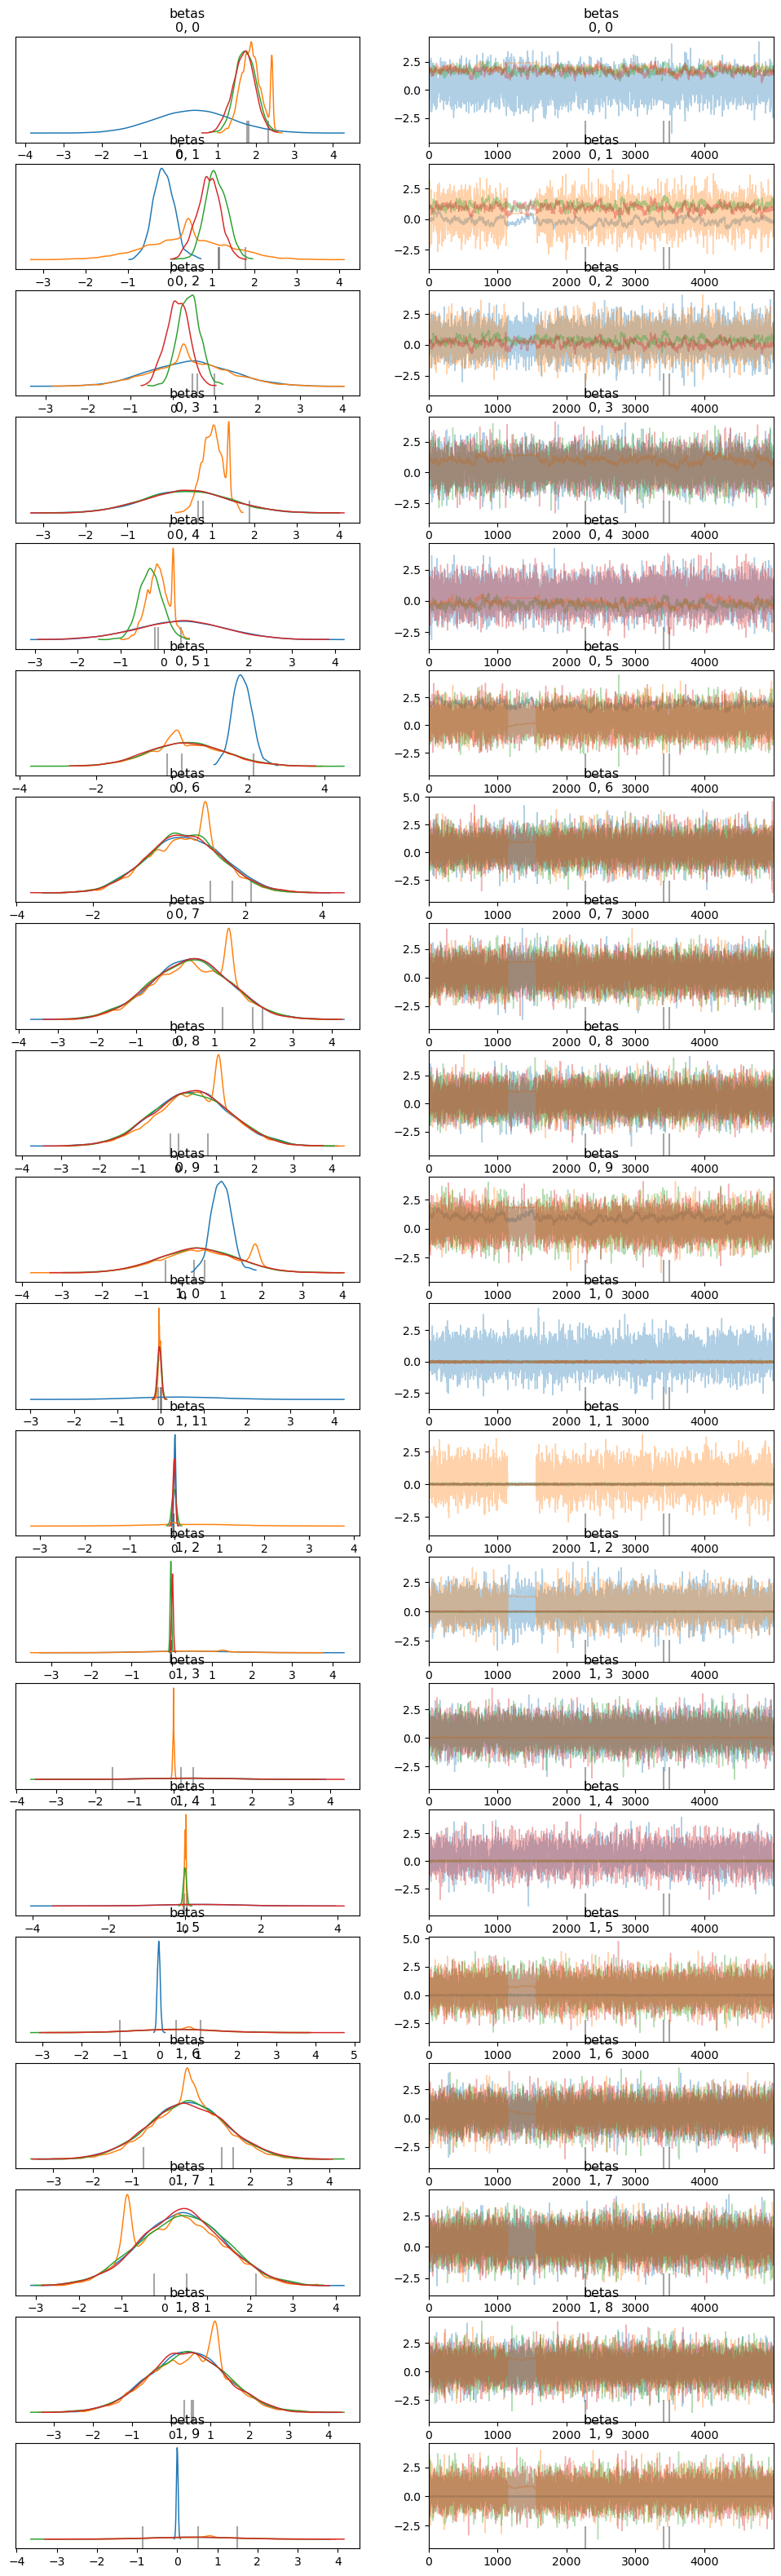

In [155]:
fit_az = az.from_cmdstanpy(fit)
az.plot_trace(fit_az,var_names=["betas"], compact=False)

array([[<AxesSubplot:title={'center':'betas\n0, 0'}>,
        <AxesSubplot:title={'center':'betas\n0, 1'}>,
        <AxesSubplot:title={'center':'betas\n0, 2'}>,
        <AxesSubplot:title={'center':'betas\n0, 3'}>],
       [<AxesSubplot:title={'center':'betas\n0, 4'}>,
        <AxesSubplot:title={'center':'betas\n0, 5'}>,
        <AxesSubplot:title={'center':'betas\n0, 6'}>,
        <AxesSubplot:title={'center':'betas\n0, 7'}>],
       [<AxesSubplot:title={'center':'betas\n0, 8'}>,
        <AxesSubplot:title={'center':'betas\n0, 9'}>,
        <AxesSubplot:title={'center':'betas\n1, 0'}>,
        <AxesSubplot:title={'center':'betas\n1, 1'}>],
       [<AxesSubplot:title={'center':'betas\n1, 2'}>,
        <AxesSubplot:title={'center':'betas\n1, 3'}>,
        <AxesSubplot:title={'center':'betas\n1, 4'}>,
        <AxesSubplot:title={'center':'betas\n1, 5'}>],
       [<AxesSubplot:title={'center':'betas\n1, 6'}>,
        <AxesSubplot:title={'center':'betas\n1, 7'}>,
        <AxesSubplot:tit

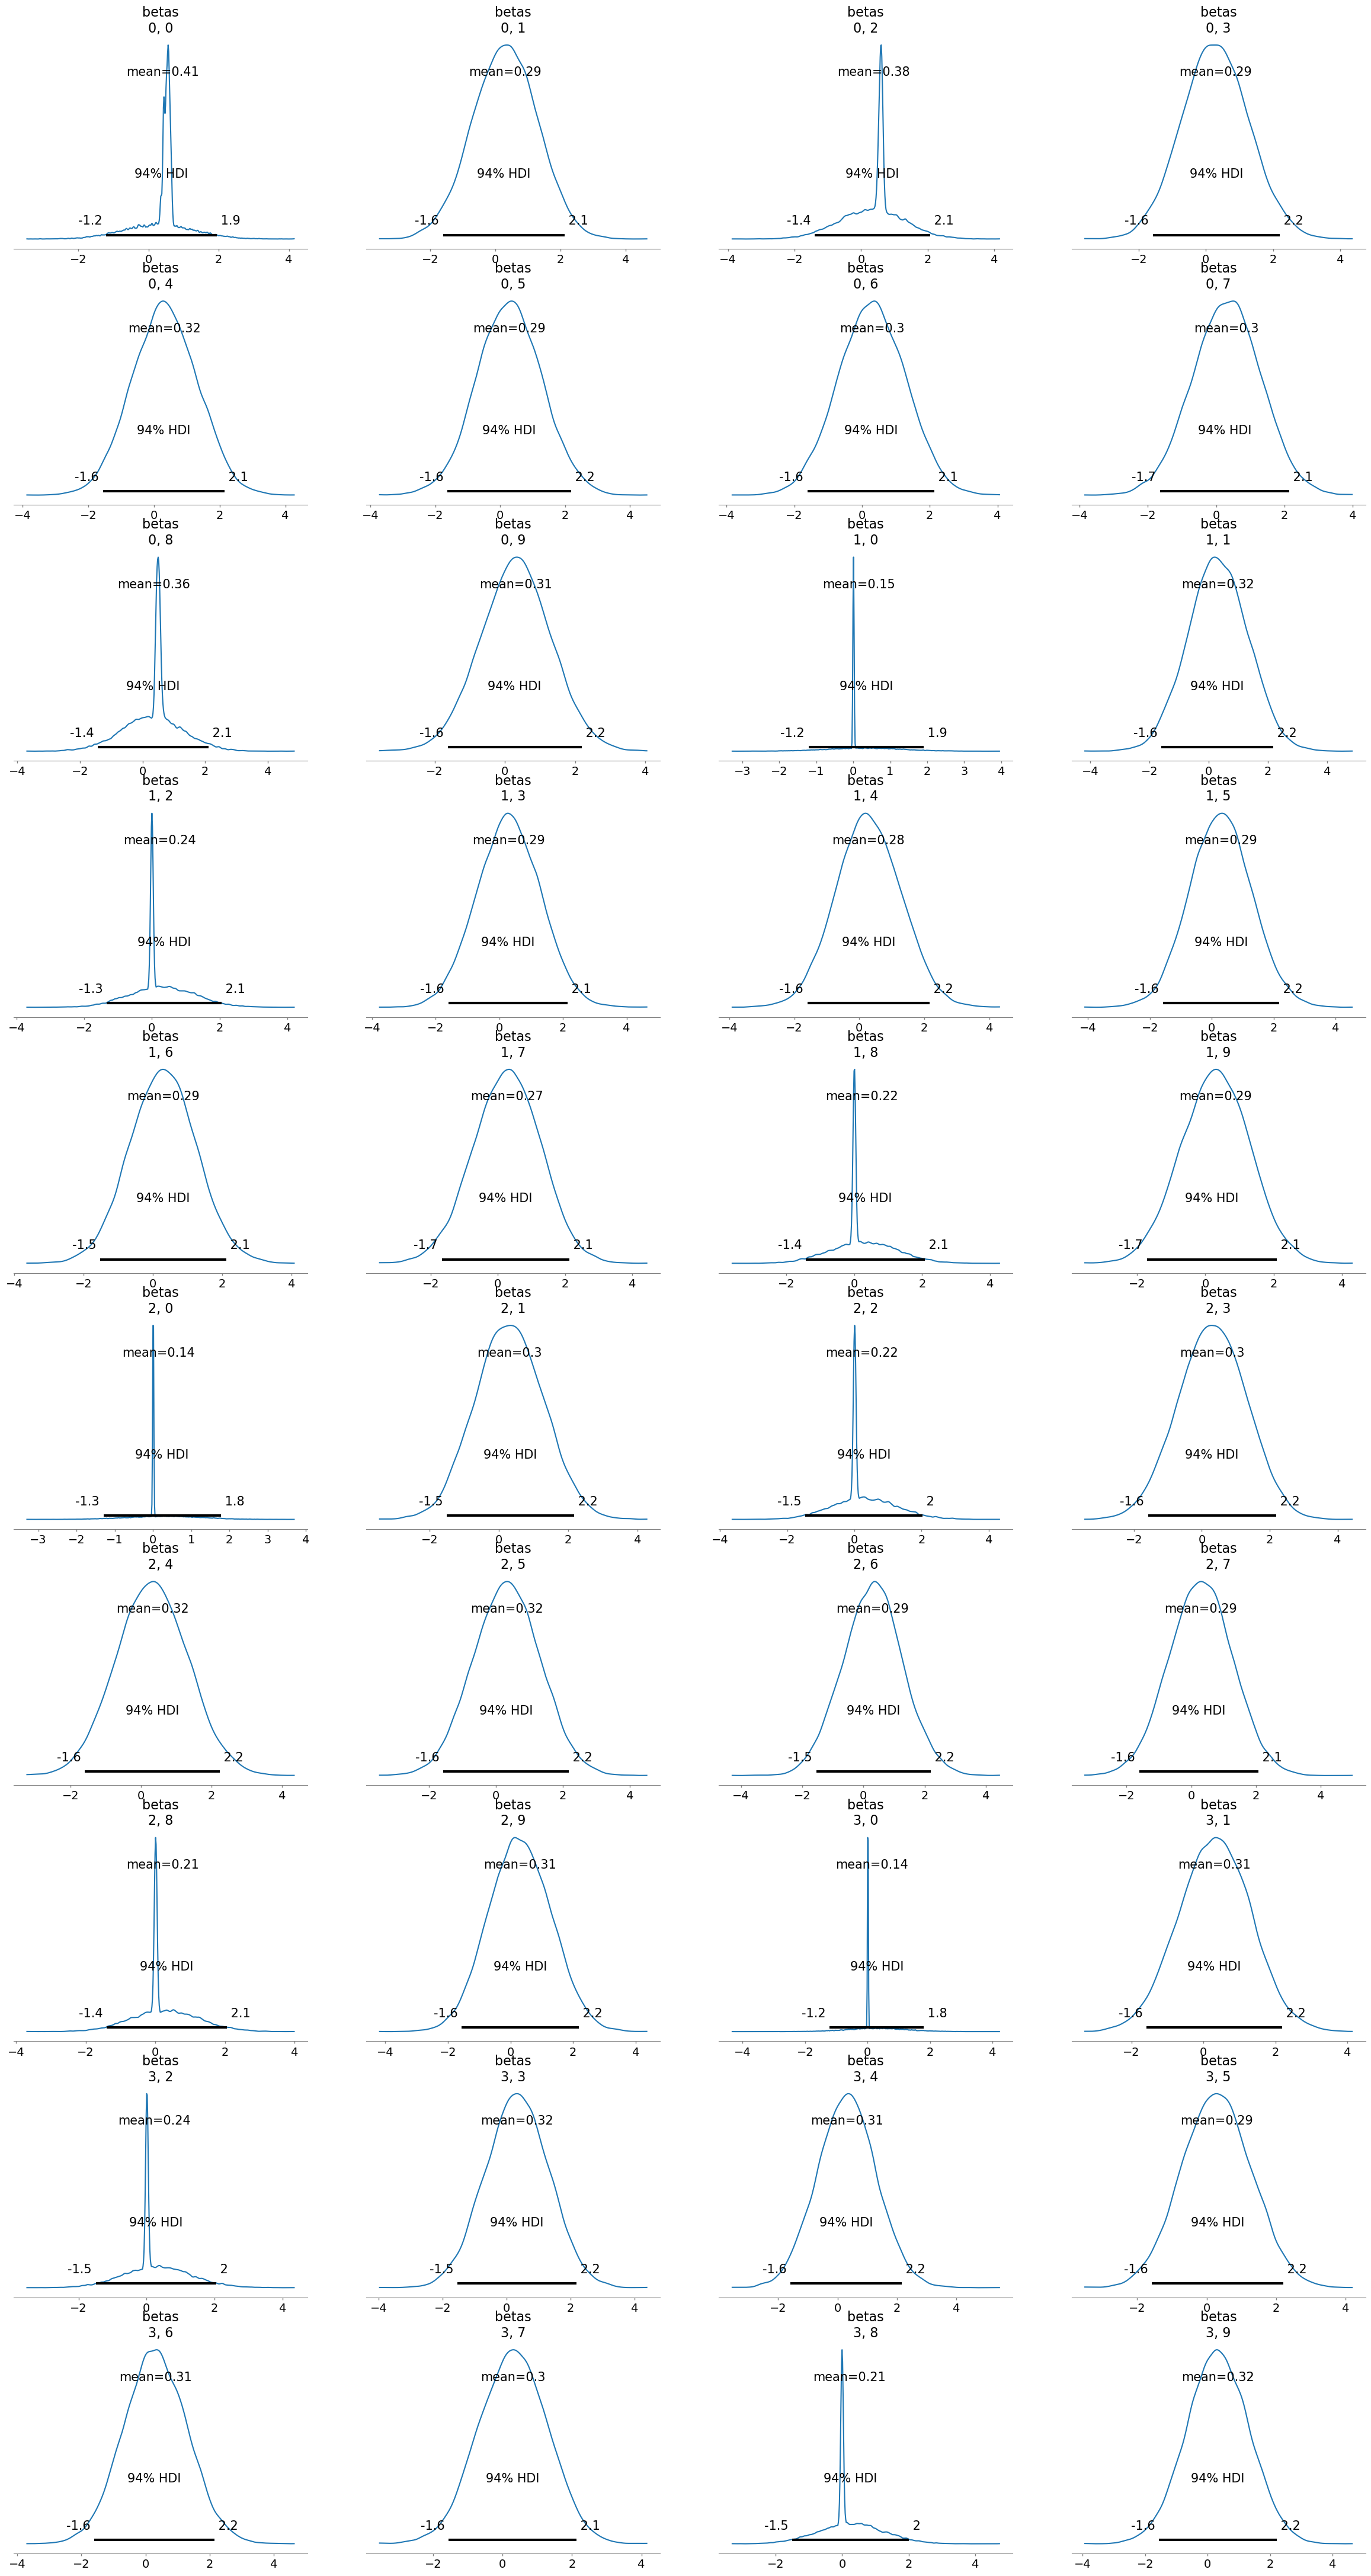

In [117]:
fit_az = az.from_cmdstanpy(fit)
az.plot_posterior(fit_az,var_names=["betas"])

In [9]:
with open("spatially_correlated_simulated_dataset.pkl", "wb") as f:
    pickle.dump({'model' : dp_mix, 'fit' : fit}, f, protocol=-1)
    # or with a list
    pickle.dump([dp_mix, fit], f, protocol=-1)
fit_az = az.from_cmdstanpy(fit)

In [10]:
#Extimate pi[i,j] to compute Binder loss
#Likely not the most clever way to compute the matrix

n_chains=4
n_iteration_per_chain=1000
Binder_matrix= np.zeros((I,I))
for n in range(n_chains):
    for m in range(n_iteration_per_chain):
        for i in range(I):
            for j in range(i-1):
                if(fit_az.posterior.s.values[n,m,i]==fit_az.posterior.s.values[n,m,j]):
                    Binder_matrix[i,j]+=1
                
Binder_matrix= Binder_matrix/(n_chains*n_iteration_per_chain)


In [11]:
#define Binder Loss

#Commented I added a penalty for a large number of clusters
#With penalty_n_clus=0 standard binder loss

def binder_function(binder_alloc):
    loss=0
    #penalty_n_clus=1
    #loss=penalty_n_clus*np.unique(binder_alloc).size
    
    for i in range(I):
        for j in range(i):
            
            if(binder_alloc[i]==binder_alloc[j]):
                    loss+=(1-Binder_matrix[i,j])
            
            else:
                loss+=(Binder_matrix[i,j])
            
    return loss

    

In [12]:
#Minimize Binder Loss evaluating the loss only 
#in the solutions found by stan model
#Not completly correct but should be a good doable approximation
n_chains=4
iteration_per_chain=1000
min_loss=10000
s_fixed=np.zeros(I)
for n in range(n_chains):
    for m in range(iteration_per_chain):
        loss=binder_function(fit_az.posterior.s.values[n,m])
        if(loss<min_loss):
            s_fixed=fit_az.posterior.s.values[n,m]

print('S_fixed')
print(s_fixed)


S_fixed
[ 8. 10.  9.  6.  7.  1.  2.  7.  1. 10. 10.  6.  1. 10. 10.  1.  7.  7.
  2.  1.  1.  9.  8.  6.  1.  6.  2.  4.  2.  7.  7.  3.  1. 10.  6.  9.
  4.  8.  3.  2.  1.  3.  5.  4.  4.  5.  8.  2.  7.  9.  8.  1.  3.  8.
  3.  8.  5.  1.  5.  7.  6. 10.  4. 10.  7.  7.  2. 10. 10.  5. 10.  8.
  3.  3.  2.  5.  5.  3.  3.  9.  7.  5. 10.  6. 10.  1.  1.  1. 10.  1.
 10.  1.  1.  2.  1. 10. 10. 10. 10.  3.]


In [ ]:
# Fixed clustering s to study betas depending on clusters
beta_clus_stan = """
data
{
    int<lower=1> I; // number of areal locations
    int<lower=1> T; // number of time steps
    int<lower=1> P; // number of covariates
    int<lower=1> H; // number of possible clusters
    
    vector[I*T]     y; // output values
    matrix[I*T,P+1] X; // covariate matrix
    // syntax: y(i,t) = y[T*(i-1) + t]
    
    matrix[I,I] W_raw; // proximity matrix
      
    // hyperpar vector of regressors
    vector[P+1]     mu_0; 
    matrix[P+1,P+1] Sigma_0;
    
    // w_1
    vector[I] mu_w_1;
    
    // alpha
    real<lower=0> a_alpha;
    real<lower=0> b_alpha;
    
    // tau^2
    real<lower=0> a_tau2;
    real<lower=0> b_tau2;
    
    // sigma^2
    real<lower=0> a_sigma2;
    real<lower=0> b_sigma2;
    
    // rho
    real<lower=0> alpha_rho;
    real<lower=0> beta_rho;
    
    //xis
    real<lower=0> a_xi;
    real<lower=0> b_xi;
    
    int s[I];
}

transformed data
{
    vector[T] ones_T;
    for (t in 1:T)
        ones_T[t] = 1;
    
    matrix[T,T] eye_T;
    eye_T = diag_matrix(ones_T);
 
    vector[I] ones_I;
    for (i in 1:I)
        ones_I[i] = 1;
    
    matrix[I,I] eye_I;
    eye_I = diag_matrix(ones_I);
        
    matrix[I,I] W;
    W = diag_matrix(W_raw*ones_I) - W_raw;
    
    
}

parameters
{
    real<lower=0> sigma2;
    real<lower=0> tau2;
    real<lower=0,upper=1> rho;
    
    
    // autoregressive coefficients still to reparametrize
    vector<lower=0,upper=1>[I]    xis_constructors;
    
    // random effects
    matrix[T,I]                ws;
    
   //Betas depend on clusters
    matrix[P+1,H]              betas_clus; 
    
    
}


model
{
    
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    rho    ~ beta(alpha_rho,beta_rho);
    
    
    xis_constructors ~ beta(a_xi,b_xi);
    vector[I] xis;
    xis = 2 * xis_constructors - 1; 
    matrix[I,I] inv_Q;
    inv_Q = inverse_spd(rho*W + (1-rho)*eye_I);
    
    ws[1,1:I] ~ multi_normal(mu_w_1, tau2*inv_Q);
    
    for (t in 2:T)
        ws[t,1:I] ~ multi_normal(ws[t-1,1:I]*diag_matrix(xis), tau2*inv_Q);
    
    for(h in 1:H)
    {
        betas_clus[1:P+1,h] ~ multi_normal(mu_0, Sigma_0);
    }
    for (i in 1:I){
        int clus_i=s[i]+1;
        
        y[T*(i-1)+1:i*T] ~ multi_normal(X[T*(i-1)+1:i*T, 1:P+1]*betas_clus[1:P+1,clus_i] + ws[1:T,i], sigma2*eye_T);
    }    
}

"""

stan_file = "beta_clus.stan"

with open(stan_file, "w") as fp:
    fp.write(beta_clus_stan)
    
beta_clus = CmdStanModel(stan_file=stan_file)

In [ ]:
s= s_fixed.astype(int)

data_clus = {
    "I": I,
    "T": T,
    "P": P,
    "H": H,
    "y": y,
    "X": X,
    "W_raw": W_raw,
    "mu_0": mu_0,
    "Sigma_0": Sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "alpha_rho": 5,
    "beta_rho": 1,
    "a_xi": 1,
    "b_xi": 1,
    "s":s
}


In [ ]:
fit_clus = beta_clus.sample(data_clus
#                     , show_console = True
#                    , chains=4
#                     , adapt_delta=0.9
#                    , step_size = 1.5
#                    , max_treedepth = 100
                   )

In [ ]:
with open("spatially_correlated_beta_clus.pkl", "wb") as f:
    pickle.dump({'model' : beta_clus, 'fit' : fit_clus}, f, protocol=-1)
    # or with a list
    pickle.dump([beta_clus, fit_clus], f, protocol=-1)